In [1]:
import pandas as pd
import numpy as np
def parse_if_number(s):
    try: return float(s)
    except: return True if s=="true" else False if s=="false" else s if s else None

def parse_ndarray(s):
    return np.fromstring(s, sep=' ') if s else None
routing = pd.read_csv('results_3node/routing.csv', converters = {
    'attrvalue': parse_if_number,
    'binedges': parse_ndarray,
    'binvalues': parse_ndarray,
    'vectime': parse_ndarray,
    'vecvalue': parse_ndarray})

col_Names=["type", "seq", "time", "host","src_ip","dst_ip","next_hop","interface"]
rtable=pd.read_csv('results_3node/General-0.rt', names=col_Names, header=None,delim_whitespace=True)




/tmp/ipykernel_26290/3710004105.py:17: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  rtable=pd.read_csv('results_3node/General-0.rt', names=col_Names, header=None,delim_whitespace=True)


In [2]:
iptable=rtable[rtable.type=="*I"]
rtable=rtable.drop(rtable[(rtable.next_hop=="<unspec>") | (rtable.type=="*I")].index)
print(iptable)

   type seq time                   host src_ip       dst_ip next_hop interface
8    *I  #0   0s   TestNetwork.relay[0]  wlan0  145.236.0.1      NaN       NaN
11   *I  #0   0s  TestNetwork.rxhost[0]  wlan0  145.236.0.2      NaN       NaN
14   *I  #0   0s  TestNetwork.txhost[0]  wlan0  145.236.0.3      NaN       NaN


In [4]:
import torch
from egnn_pytorch import EGNN
import networkx as nx
import matplotlib.pyplot as plt
params = routing[routing.type=='param']
config = routing[routing.type=='config']

numrxhosts=int(config[config.attrname=='*.numRXHosts'].iloc[0].attrvalue)
numtxhosts=int(config[config.attrname=='*.numTXHosts'].iloc[0].attrvalue)
numrxtxhosts=int(config[config.attrname=='*.numRXTXHosts'].iloc[0].attrvalue)

numrelays=int(config[config.attrname=='*.numRelays'].iloc[0].attrvalue)

print(numrxhosts)
print(routing.columns)

1
Index(['run', 'type', 'module', 'name', 'attrname', 'attrvalue', 'value',
       'count', 'sumweights', 'mean', 'stddev', 'min', 'max', 'underflows',
       'overflows', 'binedges', 'binvalues', 'vectime', 'vecvalue'],
      dtype='object')


TestNetwork.rxhost[0]
[93.2557, 0.0114381]


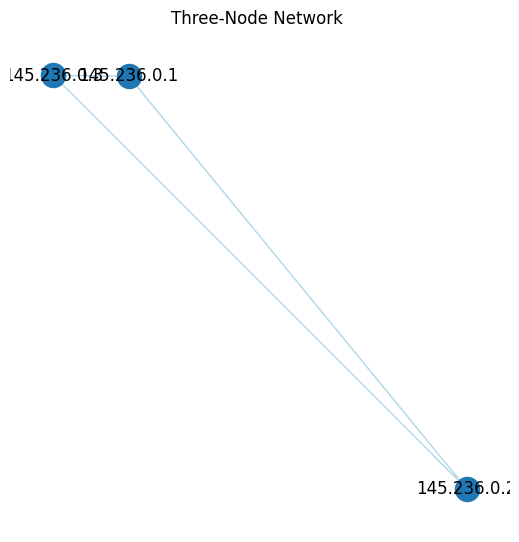

In [ ]:
# Create the graph and add nodes with positions
G = nx.Graph()

for nodeid in range(numrelays):
    nodename=f'TestNetwork.relay[{nodeid}]'
    mobility = params[(params.module==f'{nodename}.mobility')]
    xpos=float(mobility[mobility.name=='initialX'].iloc[0].value[:-1])
    ypos=float(mobility[mobility.name=='initialY'].iloc[0].value[:-1])
    pos = [xpos,ypos]
    ip= iptable[iptable.host==nodename].iloc[0].dst_ip
    tt=[0,1,0]
    G.add_node(ip, pos=pos,tt=tt,type='relay',ip=ip,name=nodename)

for nodeid in range(numrxhosts):
    nodename=f'TestNetwork.rxhost[{nodeid}]'
    mobility = params[(params.module==f'{nodename}.mobility')]
    xpos=float(mobility[mobility.name=='initialX'].iloc[0].value[:-1])
    ypos=float(mobility[mobility.name=='initialY'].iloc[0].value[:-1])
    pos = [xpos,ypos]
    ip= iptable[iptable.host==nodename].iloc[0].dst_ip
    tt=[0,0,1]
    G.add_node(ip, pos=pos,tt=tt,type='rxhost',ip=ip,name=nodename)


for nodeid in range(numtxhosts):
    nodename=f'TestNetwork.txhost[{nodeid}]'
    mobility = params[(params.module==f'{nodename}.mobility')]
    xpos=float(mobility[mobility.name=='initialX'].iloc[0].value[:-1])
    ypos=float(mobility[mobility.name=='initialY'].iloc[0].value[:-1])
    pos = [xpos,ypos]
    ip= iptable[iptable.host==nodename].iloc[0].dst_ip
    tt=[1,0,0]
    G.add_node(ip, pos=pos,tt=tt,type='rxhost',ip=ip,name=nodename)

for nodeid in range(numrxtxhosts):
    nodename=f'TestNetwork.rxtxhost[{nodeid}]'
    mobility = params[(params.module==f'{nodename}.mobility')]
    xpos=float(mobility[mobility.name=='initialX'].iloc[0].value[:-1])
    ypos=float(mobility[mobility.name=='initialY'].iloc[0].value[:-1])
    pos = [xpos,ypos]
    ip= iptable[iptable.host==nodename].iloc[0].dst_ip
    tt=[1,0,1]
    G.add_node(ip, pos=pos,tt=tt,type='rxtxhost',ip=ip,name=nodename)




for idx,route in rtable.iterrows():
    src=route.src_ip
    adjhost=route.next_hop
    G.add_edge(src,adjhost)



# Draw the graph
plt.figure(figsize=(5, 5))
pos = nx.get_node_attributes(G, 'pos')
nx.draw(G, pos, node_size=300, with_labels=True, edge_color='lightblue')
plt.title("Three-Node Network ")
plt.show()


run                             General-0-20250402-00:11:43-143
type                                                     vector
module                             TestNetwork.rxhost[0].app[1]
name                         packetReceived:vector(packetBytes)
attrname                                                    NaN
attrvalue                                                  None
value                                                       NaN
count                                                       NaN
sumweights                                                  NaN
mean                                                        NaN
stddev                                                      NaN
min                                                         NaN
max                                                         NaN
underflows                                                  NaN
overflows                                                   NaN
binedges                                

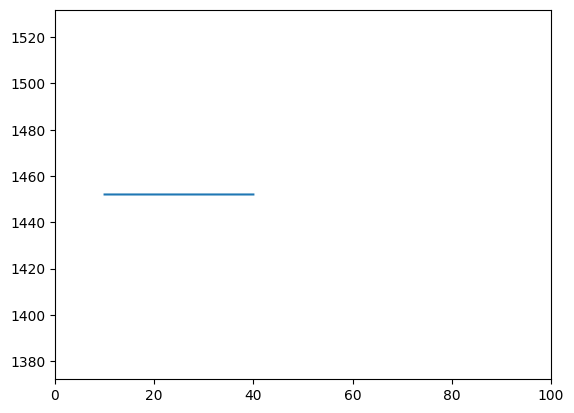

run                             General-0-20250402-00:11:43-143
type                                                     vector
module                             TestNetwork.rxhost[0].app[1]
name                         packetReceived:vector(packetBytes)
attrname                                                    NaN
attrvalue                                                  None
value                                                       NaN
count                                                       NaN
sumweights                                                  NaN
mean                                                        NaN
stddev                                                      NaN
min                                                         NaN
max                                                         NaN
underflows                                                  NaN
overflows                                                   NaN
binedges                                

In [9]:
vectors = routing[routing.type=='vector']

vec = vectors[(vectors.module=='TestNetwork.rxhost[0].app[1]')].iloc[0]# take some vector
print(vec)
print("Number of matching rows:", len(vec))

plt.plot(vec.vectime, vec.vecvalue, drawstyle='steps-post')
plt.xlim(0,100)
plt.show()
print(vec)


In [10]:
scalar = routing[routing.type=='scalar']
sca = scalar[(scalar.module=='TestNetwork.rxhost[0].app[1]') & (scalar.name=="packetReceived:sum(packetBytes)")].iloc[0]
traffic=int(sca.value)*8/90/1000/1000

In [11]:
import torch
import numpy as np
import matplotlib.pyplot as plt
# custom model
from egnn_pytorch import *

In [14]:
import torch
import torch.nn as nn

class EGNNWithReadout(nn.Module):
    def __init__(self, egnn, input_dim, output_dim, hidden_dim=None, non_linear=True):
        super().__init__()
        self.egnn = egnn
        
        if hidden_dim is None:
            hidden_dim = input_dim

        self.readout = nn.Linear(input_dim, output_dim)
    
    def forward(self, feats, coors, edges=None, mask=None, adj_mat=None):
        node_out, coors_out = self.egnn(feats, coors, edges, mask, adj_mat)
        out = self.readout(node_out)
        return out, coors_out


In [15]:
egnn_netwro  = EGNN(dim = 3, edge_dim = 1,update_coors = False)

#egnn_net = EGNN_Network(
#        depth=1,
#        dim=1,
#        edge_dim = 1,
#)
egnn_net = EGNNWithReadout(egnn_netwro, input_dim=3,hidden_dim=6, output_dim=1)


In [16]:
optimizer = torch.optim.Adam(egnn_net.parameters(), lr=1e-3)
loss_fn = torch.nn.MSELoss()

In [ ]:

feats = torch.tensor(list(nx.get_node_attributes(G, 'tt').values()), dtype=torch.float32).unsqueeze(0).unsqueeze(-1)
print(feats.shape)
featsart = torch.tensor(list([[1,0,0],[0,1,0],[0,0,1]]), dtype=torch.float32).unsqueeze(0)
print(featsart.shape)
#print(feats)
coors = torch.tensor(list(pos.values()))
zeros_col = torch.zeros(coors.shape[0], 1)
coors_tensor = coors.squeeze(0) 
#print(coors_tensor)
#diff = coors_tensor.unsqueeze(1) - coors_tensor.unsqueeze(0)
#print(diff)
#distances = torch.sqrt((diff ** 2).sum(dim=2))  # Shape: (num_nodes, num_nodes)
#print(distances)
target=torch.tensor([0,0,traffic/56]).unsqueeze(0).unsqueeze(-1) 
print(target)
# Concatenate the zeros as a new column to your coordinates tensor
coors = torch.cat([coors, zeros_col], dim=1).unsqueeze(0)

# Concatenate the zeros as a new column to your coordinates tensor
mat=nx.adjacency_matrix(G)
print(f"coors shape:{coors.shape}")
print(f"feats shape:{feats.shape}")

adj=torch.tensor(mat.toarray(), dtype=torch.float32)
edge_features = torch.ones(1,3,3,1)
print(adj)

print(edge_features.shape)

num_epochs = 10000
optimizer.zero_grad()
for epoch in range(num_epochs):
    egnn_net.train()
    optimizer.zero_grad()

    # Forward: pasar los datos por el EGNN_Network
    # Nota: si no se desean actualizar las coordenadas, la salida coors se ignora.
    node_emb, coors_updated = egnn_net(feats, coors,adj_mat=adj,edges=edge_features)
    print(node_emb.shape)
    print(target.shape)
    # Compute the MSE loss between the predicted node embeddings and the target
    loss = loss_fn(node_emb, target)
    
    # Backward pass: compute gradients
    loss.backward()
    
    # Update model parameters
    optimizer.step()
    
    # Print training progress
    print(f"Epoch {epoch}, Loss: {loss.item()}")

print(node_emb)



tensor([[[[0.],
          [1.],
          [0.]],

         [[0.],
          [0.],
          [1.]],

         [[1.],
          [0.],
          [0.]]]])
tensor([[[1., 0., 0.],
         [0., 1., 0.],
         [0., 0., 1.]]])
tensor([[[0.0000],
         [0.0000],
         [0.1080]]])
coors shape:torch.Size([1, 3, 3])
feats shape:torch.Size([1, 3, 3, 1])
tensor([[0., 1., 1.],
        [1., 0., 1.],
        [1., 1., 0.]])
torch.Size([1, 3, 3, 1])


ValueError: too many values to unpack (expected 8)

In [55]:
print(target)
print(node_emb)

tensor([[[0.0000],
         [0.0000],
         [0.1440]]])
tensor([[[-4.7684e-07],
         [-8.6427e-07],
         [ 1.4398e-01]]], grad_fn=<ViewBackward0>)
